# Deep End-to-End Photo Editing
We're taking a different approach from before: we want to design a pipeline that can be trained end-to-end on photo ediitng. We have a fixed forward model, the Lightroom model, and we need to learn a set of ediitng heuristics from a user-provided set of before-after pairs.

## Objective
We begin with a set of pristine images $X$ and edited images $Y$, from which we build image pairs $(x, y), x \in X, y \in Y$. We seek a transformation $f(\cdot): X \mapsto Y$ which minimizes the *difference* between each $x$ and $y$. This objective function $g(\cdot): X \times Y \mapsto \mathbb{R}$ is a pseudosemimetric of image perceptual similarity. Choices include:
- $L_1$ or $L_2$ distances.
- [Perceptual loss](https://arxiv.org/pdf/1603.08155.pdf) by Johnson et al.
- [Ensembled Learned Perceptual Image Patch Similarity](https://arxiv.org/pdf/1906.03973.pdf) by Kettunen et al.
- Adversarial Loss from GAN literature.

## Forward
We impose incredibly strong inductive biases on the forward model. We *know* the space of operators whose composition is the manifold of suitable transformations for this task. We use a subset of these operators, including:
- Exposure
- Contrast
- Shadows
- Highlights
- Temperature
- Tint
- Yellow saturation
- Local contrast

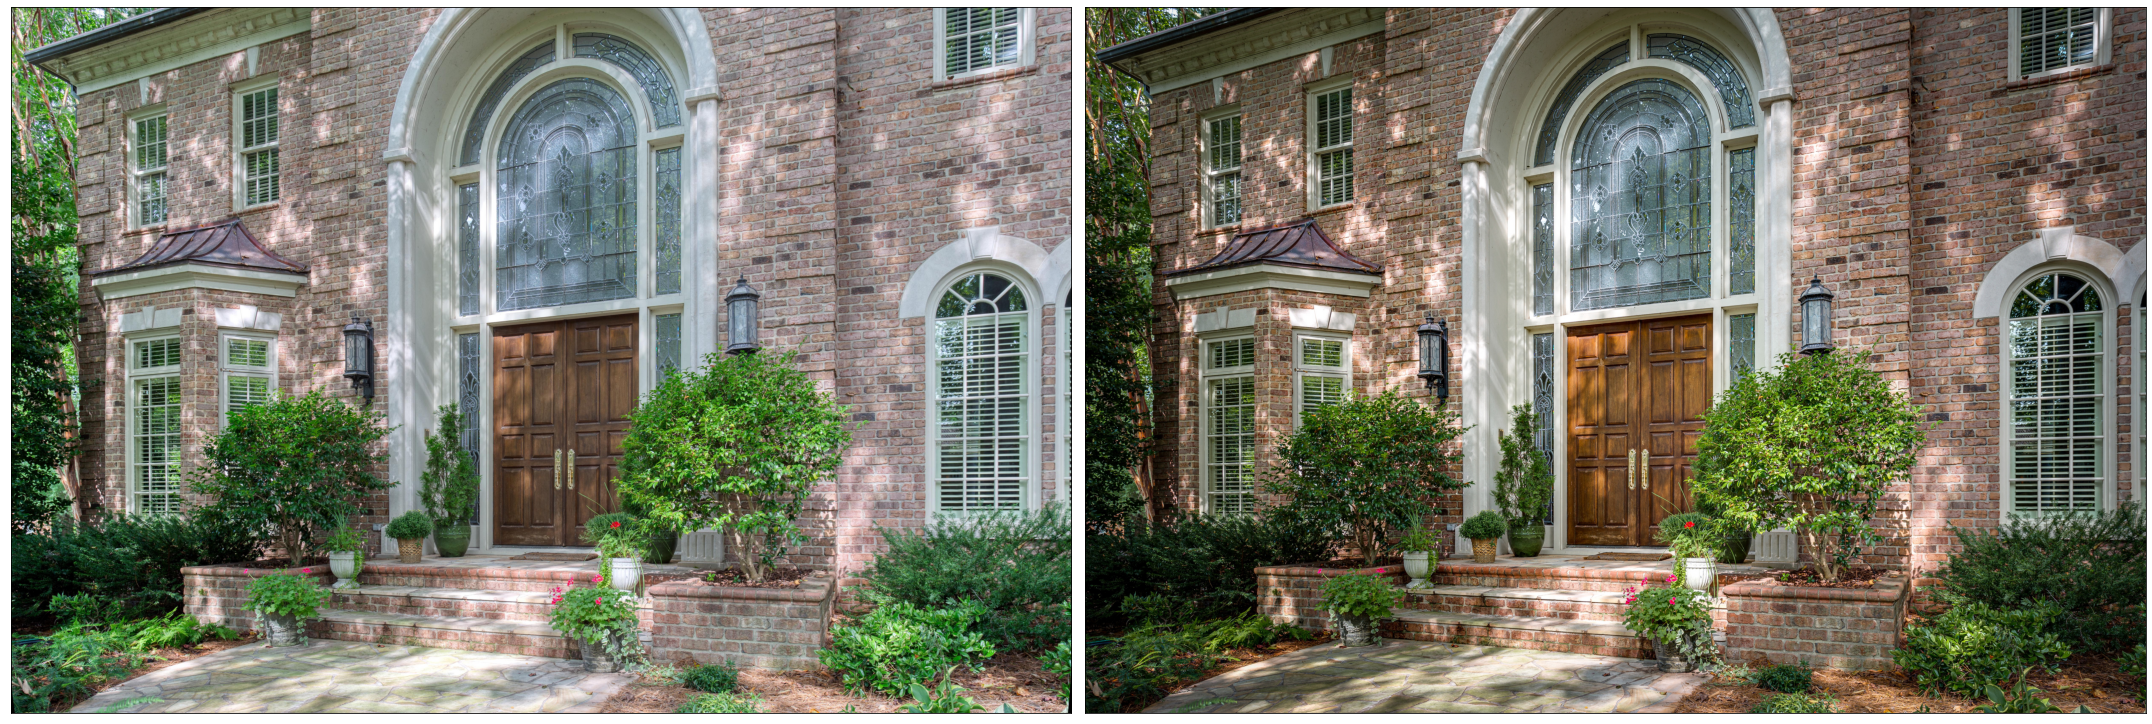

In [1]:
from numpy import asarray
from matplotlib import pyplot as plt
from PIL import Image

# Load
input = Image.open("../media/prelims/warped.jpg")
target = Image.open("../media/prelims/delivery.jpg")

# Show
plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(asarray(input))
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(asarray(target))
plt.tight_layout()
plt.show()

In [2]:
from plasma.filters import clarity, contrast, exposure, highlights, selective_color, shadows, temperature, tint
from plasma.filters.functional import radial_gradient
from torch import tensor, zeros, Tensor

def vignette (input: Tensor, weight: Tensor) -> Tensor:
    mask = radial_gradient(input, 2.5)
    mask = 1. - mask
    result = exposure(input, mask * weight)
    return result

def linear_forward (input: Tensor, weights: Tensor) -> Tensor:
    """
    Apply the linear filter forward on a given input image. The following filters are applied in order:
    - Shadows
    - Highlights
    - Contrast
    - Exposure
    - Temperature
    - Tint
    - Yellow saturation
    - Orange saturation
    - Clarity
    
    Parameters:
        input (Tensor): Input image with shape (N,3,H,W) in range [-1., 1.].
        weights (Tensor): Filter weights with shape (N,9) in range [-1., 1.].

    Returns:
        Tensor: Filtered image with shape (N,3,H,W) in range [-1., 1.].
    """
    # Linear
    input = shadows(input.clamp(min=1e-3 - 1), weights[:,0].view(-1, 1, 1, 1))
    input = highlights(input.clamp(min=1e-3 - 1), weights[:,1].view(-1, 1, 1, 1))
    input = contrast(input, weights[:,2].view(-1, 1, 1, 1))
    input = exposure(input, weights[:,3].view(-1, 1, 1, 1))
    input = temperature(input, weights[:,4].view(-1, 1, 1, 1))
    input = tint(input, weights[:,5].view(-1, 1, 1, 1))
    input = clarity(input, weights[:,6].view(-1, 1, 1, 1))
    # Selective color
    _, _, height, width = input.shape
    BASIS = tensor([
        [255., 165., 0.],
        [255., 255., 0.],
        [0., 255., 0.]
    ]) / 255.
    zero_weight = zeros(1, 3, height, width)
    sat_weight = weights[:,7:10].view(1, 3, 1, 1).expand(-1, -1, height, width)
    lum_weight = weights[:,10:13].view(1, 3, 1, 1).expand(-1, -1, height, width)
    input = selective_color(input, BASIS, zero_weight, sat_weight, lum_weight)
    # Vignette
    input = vignette(input, weights[:,13].view(-1, 1, 1, 1))
    return input

In [3]:
from torch import tensor
from torchvision.transforms import Compose, Normalize, Resize, ToPILImage, ToTensor

# Define conversion transforms
to_tensor = Compose([
    Resize(1024),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
to_image = Compose([
    Normalize(mean=[-1., -1., -1.], std=[2., 2., 2.]),
    ToPILImage()
])

# Convert to tensor
input = to_tensor(input).unsqueeze(dim=0)
target = to_tensor(target).unsqueeze(dim=0)

We test out the forward.

In [58]:
# Apply filter
weights = tensor([
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
])
result = linear_forward(input, weights)

# Write result
to_image(result.squeeze(dim=0)).save(f"filter.jpg")

## Optimization

In [4]:
from plasma.losses import PerceptualLoss
from torch import zeros
from torch.nn import L1Loss, Parameter
from torch.optim import Adam
import tableprint

# Create optimizer
weights = Parameter(data=zeros(1, 14))
optimizer = Adam([weights], lr=0.1)

# Create loss
l1_loss = L1Loss()
#perceptual_loss = PerceptualLoss()

# Print table
HEADERS = ["Iteration", "Loss"]
print()
print(tableprint.header(HEADERS))

# Optimize
for step in range(25):
    # Forward pass and compute loss
    result = linear_forward(input, weights.tanh())
    loss_total = l1_loss(result, target)
    # Backprop
    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()
    # Log 
    print(tableprint.row([f"{step}", f"{loss_total:.4f}"]))
print(tableprint.bottom(len(HEADERS)))

# Print optimum weights
print()
print("Weights", weights.tanh())

# Write result
to_image(result.squeeze(dim=0)).save(f"optimum.jpg")


╭───────────┬───────────╮
│ Iteration │      Loss │
├───────────┼───────────┤
│      0 │ 0.2213 │
│      1 │ 0.1905 │
│      2 │ 0.1914 │
│      3 │ 0.1594 │
│      4 │ 0.1567 │
│      5 │ 0.1594 │
│      6 │ 0.1524 │
│      7 │ 0.1418 │
│      8 │ 0.1347 │
│      9 │ 0.1322 │
│     10 │ 0.1286 │
│     11 │ 0.1201 │
│     12 │ 0.1134 │
│     13 │ 0.1157 │
│     14 │ 0.1158 │
│     15 │ 0.1074 │
│     16 │ 0.1016 │
│     17 │ 0.1031 │
│     18 │ 0.1026 │
│     19 │ 0.0989 │
│     20 │ 0.0978 │
│     21 │ 0.0995 │
│     22 │ 0.0966 │
│     23 │ 0.0934 │
│     24 │ 0.0955 │
╰─────────────┴─────────────╯

Weights tensor([[ 0.7104,  0.1474,  0.2798, -0.0035,  0.2505,  0.0577, -0.0176,  0.0910,
         -0.1491, -0.1182, -0.0608,  0.0201, -0.0779, -0.8919]],
       grad_fn=<TanhBackward>)
